**Workflow:**

* Exploratory Data Analysis.
* Surviving rate
* Pclass
* Name
* Sex
* Age
* SibSp, Parch
* Ticket
* Fare
* Cabin
* Embarked

**Feature Engineering:**
* Imputation on Embarked and Age columns
* Title extraction
* Ticket first letters
* Cabin first letters
* Encoding sex column
* Family size
* One Hot Encoding for all categorical variables

**Machine Learning:**
* Split data into train and test sets
* Initialize a Random Forest Classifier
* Hyperparameter Tuning with Grid Search
* Prediction


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

# We want to see whole content (non-truncated)
pd.set_option('display.max_colwidth', None)

# 1. Exploratory Data Analysis

In [2]:
train = pd.read_csv("../input/titanic/train.csv")

display(train.head())

print(train.info())
print(train.info())
print(train.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Sur

**Notes:**

* There are some missing values in Age, Embarked and Cabin columns.
* We do not need PassengerId column
* The surviving rate is 38.3% in our dataset

**Survived**
Let's start with Survived column. It contains integer 1 or 0 which correspond to surviving ( 1 = Survived, 0 = Not Survived)

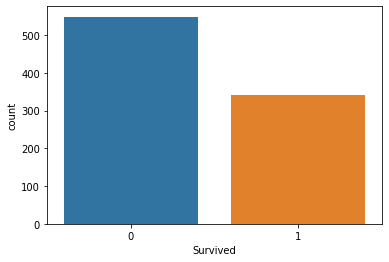

0    0.616162
1    0.383838
Name: Survived, dtype: float64


In [3]:
# Visualize with a countplot
sns.countplot(x="Survived", data=train)
plt.show()

# Print the proportions
print(train["Survived"].value_counts(normalize=True))

**Pclass**
Pclass column contains the socioeconomic status of the passengers. It might be predictive for our model

*  1 = Upper
*  2 = Middle
*  3 = Lower

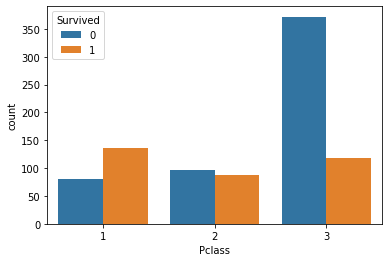

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
3    491
1    216
2    184
Name: Pclass, dtype: int64


In [4]:
# Visualize with a countplot
sns.countplot(x="Pclass", hue="Survived", data=train)
plt.show()

# Proportion of people survived for each class
print(train["Survived"].groupby(train["Pclass"]).mean())

# How many people we have in each class?
print(train["Pclass"].value_counts())

As I expected, first class passengers have higher surviving rate. We will use this information in our training data.

**Name**

At a first glance, I thought that I would use the titles.

In [5]:
# Display first five rows of the Name column
display(train[["Name"]].head())

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)"
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"


We can extract the titles from names.

In [6]:
# Get titles
train["Title"] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

# Print title counts
print(train["Title"].value_counts())


Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64


Is there any relationship between titles and surviving

In [7]:
# Print the Surviving rates by title
print(train["Survived"].groupby(train["Title"]).mean().sort_values(ascending=False))

Title
the Countess    1.000000
Mlle            1.000000
Sir             1.000000
Ms              1.000000
Lady            1.000000
Mme             1.000000
Mrs             0.792000
Miss            0.697802
Master          0.575000
Col             0.500000
Major           0.500000
Dr              0.428571
Mr              0.156673
Jonkheer        0.000000
Rev             0.000000
Don             0.000000
Capt            0.000000
Name: Survived, dtype: float64


Apparently, there is relationship between titles and surviving rate. In feature engineering part, I will group title by their surviving rates like following

* higher = the Countess, Mlle, Lady, Ms , Sir, Mme, Mrs, Miss, Master
* neutral = Major, Col, Dr
* lower = Mr, Rev, Jonkheer, Don, Capt

# Age

In [8]:
# Print the missing values in Age column
print(train["Age"].isnull().sum())

177


There are 177 missing values in Age column, we will impute them in Feature engineering part. 
Now, let's look at the distribution of ages by surviving

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


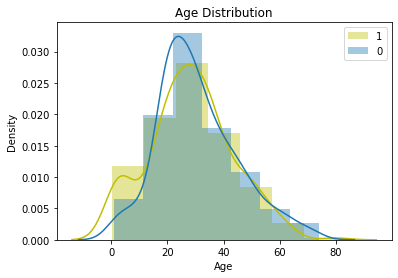

In [9]:
# Survived by age
sns.distplot(train[train.Survived==1]["Age"],color="y", bins=7, label="1")

# Death by age
sns.distplot(train[train.Survived==0]["Age"], bins=7, label="0")
plt.legend()
plt.title("Age Distribution")
plt.show()

# **Sex**

Is sex important for surviving?

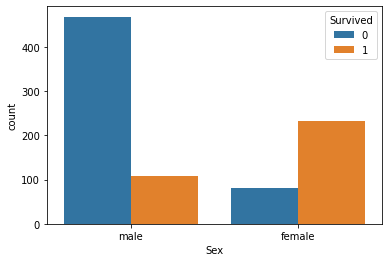

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
male      577
female    314
Name: Sex, dtype: int64


In [10]:
# Visualize with a countplot
sns.countplot(x="Sex", hue="Survived", data=train)
plt.show()

# Proportion of people survived for each class
print(train["Survived"].groupby(train["Sex"]).mean())

# How many people we have in each class?
print(train["Sex"].value_counts())

Obviously, there is a relationship between sex and surviving.

* SibSp & Parch
* SibSp = Sibling or Spouse number
* Parch = Parent or Children number

I decided to make a new feature called family size by summing the SibSp and Parch columns

In [11]:
print(train["SibSp"].value_counts())

print(train["Parch"].value_counts())

train["family_size"] = train["SibSp"] + train["Parch"]

print(train["family_size"].value_counts())

# Proportion of people survived for each class
print(train["Survived"].groupby(train["family_size"]).mean().sort_values(ascending=False))

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: family_size, dtype: int64
family_size
3     0.724138
2     0.578431
1     0.552795
6     0.333333
0     0.303538
4     0.200000
5     0.136364
7     0.000000
10    0.000000
Name: Survived, dtype: float64


Apparently, family size is important to survive. I am going to group them in feature engineering step like following

* **big family** = if family size > 3
* **small family** = if family size > 0 and family size < =3
* **alone** = family size == 0

Ticket

At first, I thought that I would drop this column but after exploration I found useful features.

In [12]:
# Print the first five rows of the Ticket column
print(train["Ticket"].head(15))

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
Name: Ticket, dtype: object


I extracted only first letters of the tickets because I thought that they would indicate the ticket type.



In [13]:
# Get first letters of the tickets
train["Ticket_first"] = train["Ticket"].apply(lambda x: str(x)[0])

# Print value counts
print(train["Ticket_first"].value_counts())

# Surviving rates of first letters
print(train.groupby("Ticket_first")["Survived"].mean().sort_values(ascending=False))

3    301
2    183
1    146
P     65
S     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_first, dtype: int64
Ticket_first
9    1.000000
P    0.646154
1    0.630137
F    0.571429
2    0.464481
C    0.340426
S    0.323077
L    0.250000
3    0.239203
4    0.200000
6    0.166667
W    0.153846
7    0.111111
A    0.068966
5    0.000000
8    0.000000
Name: Survived, dtype: float64


The first letters of the tickets are correlated with surviving rate somehow. I am going to group them like following

* higher surviving rate = F, 1, P , 9
* neutral = S, C, 2
* lower surviving rate = else

Fare
We can plot a histogram to see Fare distribution

(-0.512, 170.776]     871
(170.776, 341.553]     17
(341.553, 512.329]      3
Name: Fare, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


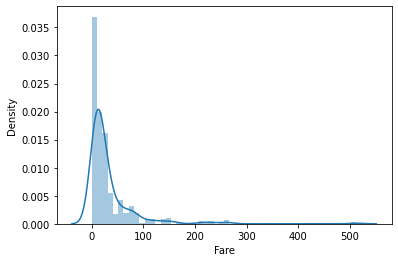

Fare
(-0.512, 170.776]     0.376579
(170.776, 341.553]    0.647059
(341.553, 512.329]    1.000000
Name: Survived, dtype: float64


In [14]:
# Print 3 bins of Fare column
print(pd.cut(train['Fare'], 3).value_counts())

# Plot the histogram
sns.distplot(train["Fare"])
plt.show()

# Print binned Fares by surviving rate
print(train['Survived'].groupby(pd.cut(train['Fare'], 3)).mean())

There is also a correlation between ticket fares and surviving

Cabin

![https://raw.githubusercontent.com/Bhasfe/titanic/ae0e2f00f9945227a26005447626f3f6a703c60b/images/titanic.png](http://)

I found this figure wikiwand.com. The figure shows us the most affacted parts of the Titanic and the Cabin locations. Although there are many missing value in Cabin column, I decided to extract the Cabin information to try whether it works or not.

In [15]:
# Print the unique values in the Cabin column
print(train["Cabin"].unique())

# Get the first letters of Cabins
train["Cabin_first"] = train["Cabin"].apply(lambda x: str(x)[0])

# Print value counts of first letters
print(train["Cabin_first"].value_counts())

# Surviving rate of Cabin first letters
print(train.groupby("Cabin_first")["Survived"].mean().sort_values(ascending=False))

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']
n    687
C     59
B     47
D     33
E     3

According to surviving rates. I will group the Cabins like following

* higher surviving rate = D, E, B, F, C
* neutral = G, A
* lower surviving rate else

**Embarked**

Embarked is a categorical features which shows us the port of embarkation.

* C = Cherbourg
* Q = Queenstown
* S = Southampton

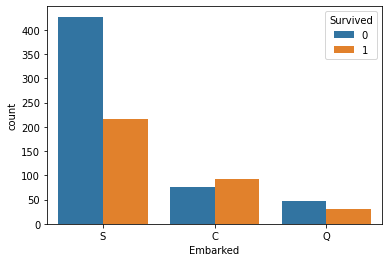

S    644
C    168
Q     77
Name: Embarked, dtype: int64
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


In [16]:
# Make a countplot
sns.countplot(x="Embarked", hue="Survived", data=train)
plt.show()

# Print the value counts
print(train["Embarked"].value_counts())

# Surviving rates of Embarked
print(train["Survived"].groupby(train["Embarked"]).mean())

No doubt, C has the higher surviving rate. 
We will definetely use this information.

# 2. Feature Engineering
We have learned a lot from exploratory data analysis. Now we can start feature engineering. Firstly, let's load the train and the test sets.

In [17]:
# Load the train and the test datasets
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


There is one missing value in the Fare column of the test set. I imputed it by using mean.

In [18]:
# Put the mean into the missing value
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

I have used two types of Imputer from sklearn. Iterative imputer for age imputation, and Simple imputer ( with most frequent strategy) for Embarked

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Imputers
imp_embarked = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_age = IterativeImputer(max_iter=100, random_state=34, n_nearest_features=2)

# Impute Embarked
train["Embarked"] = imp_embarked.fit_transform(train[["Embarked"]])
test["Embarked"] = imp_embarked.transform(test[["Embarked"]])

# Impute Age
train["Age"] = np.round(imp_age.fit_transform(train[["Age"]]))
test["Age"] = np.round(imp_age.transform(test[["Age"]]))

We also encode the sex column.

In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize a Label Encoder
le = LabelEncoder()

# Encode Sex
train["Sex"] = le.fit_transform(train[["Sex"]].values.ravel())
test["Sex"] = le.fit_transform(test[["Sex"]].values.ravel())

In EDA, we decided to use family size feature

In [21]:
# Family Size
train["Fsize"] = train["SibSp"] + train["Parch"]
test["Fsize"] = test["SibSp"] + test["Parch"]

Ticket first letters and Cabin first letters are also needed

In [22]:
# Ticket first letters
train["Ticket"] = train["Ticket"].apply(lambda x: str(x)[0])
test["Ticket"] = test["Ticket"].apply(lambda x: str(x)[0])

# Cabin first letters
train["Cabin"] = train["Cabin"].apply(lambda x: str(x)[0])
test["Cabin"] = test["Cabin"].apply(lambda x: str(x)[0])

Extract the titles from the names

In [23]:
# Titles
train["Title"] = train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
test["Title"] = test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

Now, we need some helper functions to group our categories

In [24]:
# Group the family_size column
def assign_passenger_label(family_size):
    if family_size == 0:
        return "Alone"
    elif family_size <=3:
        return "Small_family"
    else:
        return "Big_family"
    
# Group the Ticket column
def assign_label_ticket(first):
    if first in ["F", "1", "P", "9"]:
        return "Ticket_high"
    elif first in ["S", "C", "2"]:
        return "Ticket_middle"
    else:
        return "Ticket_low"
    
# Group the Title column    
def assign_label_title(title):
    if title in ["the Countess", "Mlle", "Lady", "Ms", "Sir", "Mme", "Mrs", "Miss", "Master"]:
        return "Title_high"
    elif title in ["Major", "Col", "Dr"]:
        return "Title_middle"
    else:
        return "Title_low"
    
# Group the Cabin column  
def assign_label_cabin(cabin):
    if cabin in ["D", "E", "B", "F", "C"]:
        return "Cabin_high"
    elif cabin in ["G", "A"]:
        return "Cabin_middle"
    else:
        return "Cabin_low"

Apply the functions.

In [25]:
# Family size
train["Fsize"] = train["Fsize"].apply(assign_passenger_label)
test["Fsize"] = test["Fsize"].apply(assign_passenger_label)

# Ticket
train["Ticket"] = train["Ticket"].apply(assign_label_ticket)
test["Ticket"] = test["Ticket"].apply(assign_label_ticket)

# Title
train["Title"] = train["Title"].apply(assign_label_title)
test["Title"] = test["Title"].apply(assign_label_title)

# Cabin
train["Cabin"] = train["Cabin"].apply(assign_label_cabin)
test["Cabin"] = test["Cabin"].apply(assign_label_cabin)

It's time to use One Hot Encoding

In [26]:
train = pd.get_dummies(columns=["Pclass", "Embarked", "Ticket", "Cabin","Title", "Fsize"], data=train, drop_first=True)
test = pd.get_dummies(columns=["Pclass", "Embarked", "Ticket", "Cabin", "Title", "Fsize"], data=test, drop_first=True)

Drop the colums that are no longer needed

In [27]:
target = train["Survived"]
train.drop(["Survived", "SibSp", "Parch", "Name", "PassengerId"], axis=1, inplace=True)
test.drop(["SibSp", "Parch", "Name","PassengerId"], axis=1, inplace=True)

Final look

In [28]:
display(train.head())
display(test.head())

print(train.info())
print(test.info())

,Sex,Age,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Ticket_Ticket_low,Ticket_Ticket_middle,Cabin_Cabin_low,Cabin_Cabin_middle,Title_Title_low,Title_Title_middle,Fsize_Big_family,Fsize_Small_family
0,1,22.0,7.2500,0,1,0,1,1,0,1,0,1,0,0,1
1,0,38.0,71.2833,0,0,0,0,0,0,0,0,0,0,0,1
2,0,26.0,7.9250,0,1,0,1,0,1,1,0,0,0,0,0
3,0,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,1
4,1,35.0,8.0500,0,1,0,1,1,0,1,0,1,0,0,0


,Sex,Age,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Ticket_Ticket_low,Ticket_Ticket_middle,Cabin_Cabin_low,Cabin_Cabin_middle,Title_Title_low,Title_Title_middle,Fsize_Big_family,Fsize_Small_family
0,1,34.0,7.8292,0,1,1,0,1,0,1,0,1,0,0,0
1,0,47.0,7.0000,0,1,0,1,1,0,1,0,0,0,0,1
2,1,62.0,9.6875,1,0,1,0,0,1,1,0,1,0,0,0
3,1,27.0,8.6625,0,1,0,1,1,0,1,0,1,0,0,0
4,0,22.0,12.2875,0,1,0,1,1,0,1,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sex                   891 non-null    int64  
 1   Age                   891 non-null    float64
 2   Fare                  891 non-null    float64
 3   Pclass_2              891 non-null    uint8  
 4   Pclass_3              891 non-null    uint8  
 5   Embarked_Q            891 non-null    uint8  
 6   Embarked_S            891 non-null    uint8  
 7   Ticket_Ticket_low     891 non-null    uint8  
 8   Ticket_Ticket_middle  891 non-null    uint8  
 9   Cabin_Cabin_low       891 non-null    uint8  
 10  Cabin_Cabin_middle    891 non-null    uint8  
 11  Title_Title_low       891 non-null    uint8  
 12  Title_Title_middle    891 non-null    uint8  
 13  Fsize_Big_family      891 non-null    uint8  
 14  Fsize_Small_family    891 non-null    uint8  
dtypes: float64(2), int64(1)

# 3. Machine Learning

To evaluate our model's performance, we need to split our train data into training and test sets.

In [29]:
from sklearn.model_selection import train_test_split

# Select the features and the target
X = train.values
y = target.values

# Split the data info training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

I have used GridSearchCV for tuning my Random Forest Classifier

In [30]:
# Import Necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Initialize a RandomForestClassifier
rf = RandomForestClassifier(random_state=34)

params = {'n_estimators': [50, 100, 200, 300, 350],
          'max_depth': [3,4,5,7, 10,15,20],
          'criterion':['entropy', 'gini'],
          'min_samples_leaf' : [1, 2, 3, 4, 5, 10],
          'max_features':['auto'],
          'min_samples_split': [3, 5, 10, 15, 20],
          'max_leaf_nodes':[2,3,4,5],
          }

clf = GridSearchCV(estimator=rf,param_grid=params,cv=10, n_jobs=-1)

clf.fit(X_train, y_train.ravel())

print(clf.best_estimator_)
print(clf.best_score_)

rf_best = clf.best_estimator_

# Predict from the test set
y_pred = clf.predict(X_test)

# Print the accuracy with accuracy_score function
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

RandomForestClassifier(max_depth=4, max_leaf_nodes=5, min_samples_split=15,
                       n_estimators=350, random_state=34)
0.8397691705790298
Accuracy:  0.7988826815642458

Confusion Matrix

[[98 12]
 [24 45]]


Save the model



In [31]:
pickle.dump(rf_best, open("model.pkl", 'wb'))


We can look at the feature importances.

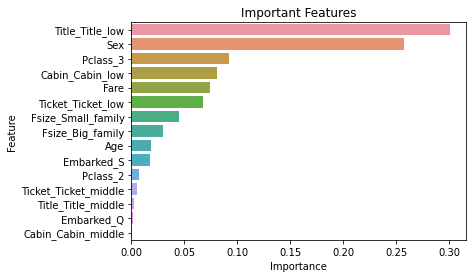

In [32]:
# Create a pandas series with feature importances
importance = pd.Series(rf_best.feature_importances_,index=train.columns).sort_values(ascending=False)

sns.barplot(x=importance, y=importance.index)
# Add labels to your graph
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title("Important Features")
plt.show()

Train the model again with entire train data.



In [33]:
last_clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=5, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=True, random_state=34, verbose=0,
                       warm_start=False)

last_clf.fit(train, target)
print("%.4f" % last_clf.oob_score_)

0.8238


Prepare the submission file



In [34]:
# Store passenger ids
ids = pd.read_csv("test.csv")[["PassengerId"]].values

# Make predictions
predictions = last_clf.predict(test.values)

# Print the predictions
print(predictions)

# Create a dictionary with passenger ids and predictions
df = {'PassengerId': ids.ravel(), 'Survived':predictions}

# Create a DataFrame named submission
submission = pd.DataFrame(df)

# Display the first five rows of submission
display(submission.head())

# Save the file
submission.to_csv("submission_last.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'